# Levy Stable models of Stochastic Volatility

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution through a motivating example of a non-Gaussian stochastic volatilty model.

Inference with stable distribution is tricky because the density `Stable.log_prob()` is very expensive. In this tutorial we demonstrate three approaches to inference: (i) using the [poutine.reparam](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) effect to transform models in to a tractable form, (ii) using the likelihood-free loss [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) with SVI, and (iii) using `Stable.log_prob()` which has a numerically integrated log-probability calculation.


#### Summary

- [Stable.log_prob()](http://docs.pyro.ai/en/stable/distributions.html#stable) is very expensive.
- Stable inference requires either reparameterization or a likelihood-free loss.
- Reparameterization:
    - The [poutine.reparam()](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) handler can transform models using various [strategies](http://docs.pyro.ai/en/latest/infer.reparam.html).
    - The [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) strategy can be used for Stable distributions in SVI or HMC.
    - The [LatentStableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.LatentStableReparam) strategy is a little cheaper, but cannot be used for likelihoods.
    - The [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosine) strategy improves geometry in batched latent time series models.
- Likelihood-free loss with SVI:
    - The [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) loss allows stable distributions in the guide and in model likelihoods.

#### Table of contents

- [Daily S&P data](#data)
- [Fitting a single distribution to log returns](#fitting) using `EnergyDistance`
- [Modeling stochastic volatility](#modeling) using:
    - [Reparameterization](#reparam) with `poutine.reparam`
    - [Numerically integrated log-probability](#numeric) with `Stable.log_prob()`

## Daily S&P 500 data <a class="anchor" id="data"></a>

The following daily closing prices for the S&P 500 were loaded from [Yahoo finance](https://finance.yahoo.com/quote/%5EGSPC/history/).

In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

%matplotlib inline
assert pyro.__version__.startswith('1.9.1')
smoke_test = ('CI' in os.environ)

In [2]:
df = load_snp500()
dates = df.Date.to_numpy()
x = torch.tensor(df["Close"]).float()
x.shape

torch.Size([23116])

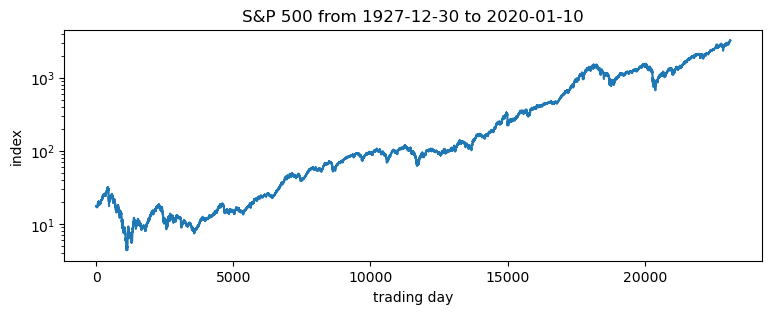

In [3]:
pyplot.figure(figsize=(9, 3))
pyplot.plot(x)
pyplot.yscale('log')
pyplot.ylabel("index")
pyplot.xlabel("trading day")
pyplot.title("S&P 500 from {} to {}".format(dates[0], dates[-1]));


Of interest are the log returns, i.e. the log ratio of price on two subsequent days.

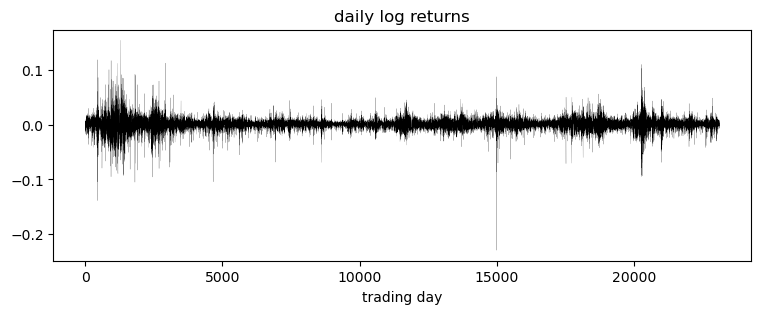

In [4]:
pyplot.figure(figsize=(9, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1)
pyplot.title("daily log returns")
pyplot.xlabel("trading day");

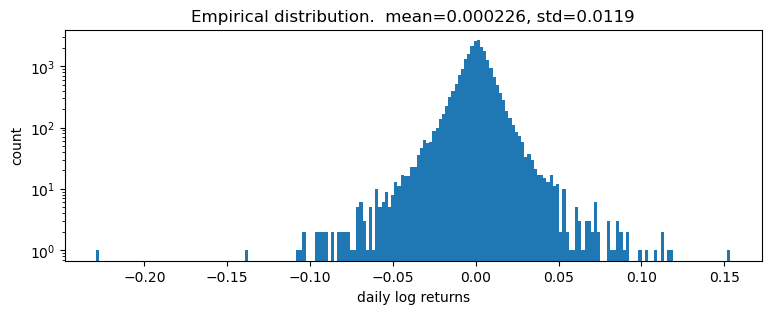

In [5]:
pyplot.figure(figsize=(9, 3))
pyplot.hist(r.numpy(), bins=200)
pyplot.yscale('log')
pyplot.ylabel("count")
pyplot.xlabel("daily log returns")
pyplot.title("Empirical distribution.  mean={:0.3g}, std={:0.3g}".format(r.mean(), r.std()));

## Fitting a single distribution to log returns  <a class="anchor" id="fitting"></a>

Log returns appear to be heavy-tailed. First let's fit a single distribution to the returns. To fit the distribution, we'll use a likelihood free statistical inference algorithm [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance), which matches fractional moments of observed data and can handle data with heavy tails.

In [6]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 7.497945785522461
step 20 loss = 2.0790653228759766
step 40 loss = 1.6773109436035156
step 60 loss = 1.4146158695220947
step 80 loss = 1.306936502456665
step 100 loss = 1.2835698127746582
step 120 loss = 1.2812254428863525
step 140 loss = 1.2803162336349487
step 160 loss = 1.2787212133407593
step 180 loss = 1.265405535697937
step 200 loss = 1.2878881692886353
--------------------
loc = 0.0002415
scale = 0.008325
stability = 1.982
CPU times: total: 828 ms
Wall time: 2.93 s


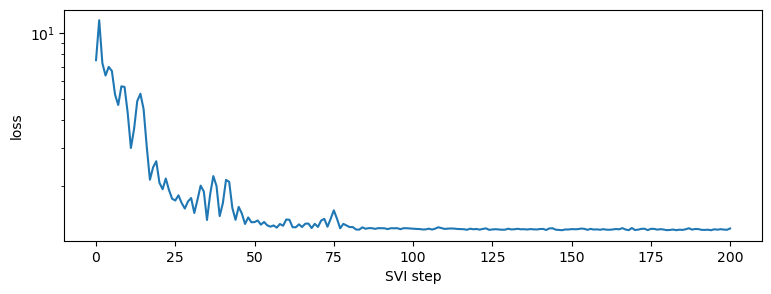

In [7]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

print("-" * 20)
pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.yscale("log")
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.squeeze().item()))

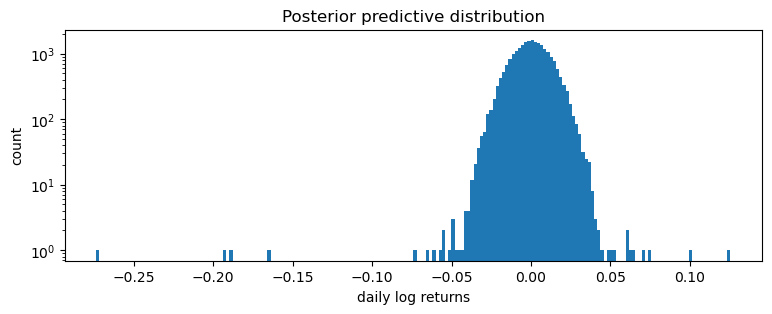

In [8]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(9, 3))
pyplot.hist(samples.numpy(), bins=200)
pyplot.yscale("log")
pyplot.xlabel("daily log returns")
pyplot.ylabel("count")
pyplot.title("Posterior predictive distribution");


This is a poor fit, but that was to be expected since we are mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling stochastic volatility  <a class="anchor" id="modeling"></a>

We'll next fit a stochastic volatility model.
Let's begin with a constant volatility model where log price $p$ follows Brownian motion

$$
  \log p_t = \log p_{t-1} + w_t \sqrt h
$$

where $w_t$ is a sequence of standard white noise. We can rewrite this model in terms of the log returns $r_t=\log(p_t\,/\,p_{t-1})$:

$$
  r_t = w_t \sqrt h
$$

Now to account for [volatility clustering](https://en.wikipedia.org/wiki/Volatility_clustering) we can generalize to a stochastic volatility model where volatility $h$ depends on time $t$. Among the simplest such models is one where $h_t$ follows geometric Brownian motion

$$
  \log h_t = \log h_{t-1} + \sigma v_t
$$

where again $v_t$ is a sequence of standard white noise. The entire model thus consists of a geometric Brownian motion $h_t$ that determines the diffusion rate of another geometric Brownian motion $p_t$:

$$
  \log h_t = \log h_{t-1} + \sigma v_t \\
  \log p_t = \log p_{t-1} + w_t \sqrt h_t
$$

Usually $v_1$ and $w_t$ are both Gaussian. We will generalize to a Stable distribution for $w_t$, learning three parameters (stability, skew, and location), but still scaling by $\sqrt h_t$.

Our Pyro model will sample the increments $v_t$ and record the computation of $\log h_t$ via [pyro.deterministic](http://docs.pyro.ai/en/stable/primitives.html#pyro.deterministic). Note that there are many ways of implementing this model in Pyro, and geometry can vary depending on implementation. The following version seems to have good geometry, when combined with reparameterizers.

In [9]:
def model(data):
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_0 = pyro.sample("h_0", dist.Normal(0, 1)).unsqueeze(-1)
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1)).unsqueeze(-1)
    v = pyro.sample("v", dist.Normal(0, 1).expand(data.shape).to_event(1))
    log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=-1))
    sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

    # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(0, 2)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h).to_event(1),
                obs=data)

### Fitting a Model with Reparameterization <a class="anchor" id="reparam"></a>

We use two reparameterizers: [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) to handle the `Stable` likelihood (since `Stable.log_prob()` is very expensive), and [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosineReparam) to improve geometry of the latent Gaussian process for `v`. We'll then use `reparam_model` for both inference and prediction.

In [10]:
reparam_model = poutine.reparam(model, {"v": DiscreteCosineReparam(),
                                        "r": StableReparam()})

step 0 loss = 2244.54
step 200 loss = -1.16091
step 400 loss = -2.96091
step 600 loss = -3.01823
step 800 loss = -3.03623
step 1000 loss = -3.04261
step 1200 loss = -3.07324
step 1400 loss = -3.06965
step 1600 loss = -3.08399
step 1800 loss = -3.08298
step 2000 loss = -3.08325
step 2200 loss = -3.09142
step 2400 loss = -3.09739
step 2600 loss = -3.10487
step 2800 loss = -3.09952
step 3000 loss = -3.10444
--------------------
h_0 = -0.2587 ± 0.00434
r_loc = 0.04707 ± 0.002965
r_skew = 0.001134 ± 0.0001323
r_stability = 1.946 ± 0.001327
sigma = 0.1359 ± 6.603e-05
CPU times: total: 19.7 s
Wall time: 2min 54s


(-3.119090303321589, 20.0)

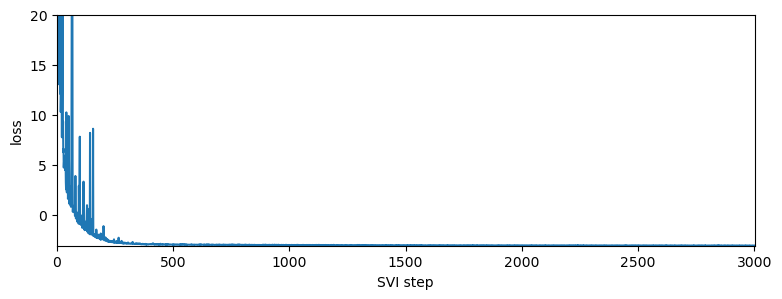

In [11]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)

def fit_model(model):
    num_steps = 1 if smoke_test else 3001
    optim = ClippedAdam({"lr": 0.05, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps)})
    guide = AutoDiagonalNormal(model)
    svi = SVI(model, guide, optim, Trace_ELBO())
    losses = []
    stats = []
    for step in range(num_steps):
        loss = svi.step(r) / len(r)
        losses.append(loss)
        stats.append(guide.quantiles([0.325, 0.675]).items())
        if step % 200 == 0:
            median = guide.median()
            print("step {} loss = {:0.6g}".format(step, loss))

    return guide, losses, stats

guide, losses, stats = fit_model(reparam_model)

print("-" * 20)
for name, (lb, ub) in sorted(stats[-1]):
    if lb.numel() == 1:
        lb = lb.squeeze().item()
        ub = ub.squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

pyplot.figure(figsize=(9, 3))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
pyplot.xlim(0, len(losses))
pyplot.ylim(min(losses), 20)


It appears the log returns exhibit very little skew, but exhibit a stability parameter slightly but significantly less than 2. This contrasts the usual Normal model corresponding to a Stable distribution with skew=0 and stability=2. We can now visualize the estimated volatility:

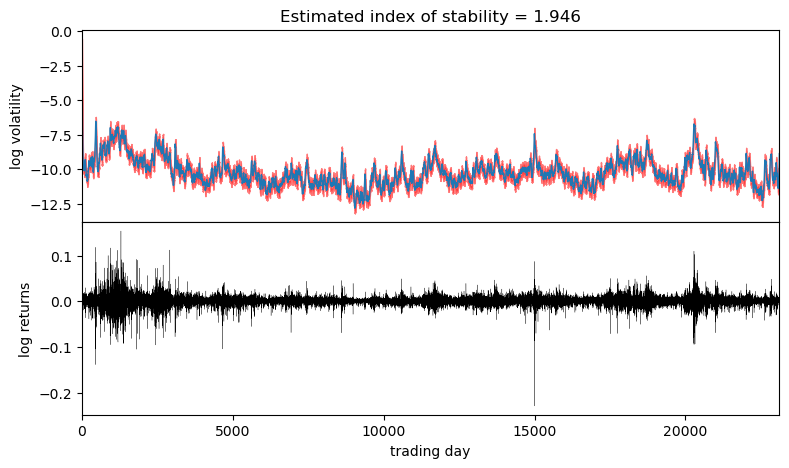

In [12]:
fig, axes = pyplot.subplots(2, figsize=(9, 5), sharex=True)
pyplot.subplots_adjust(hspace=0)
axes[1].plot(r, "k", lw=0.2)
axes[1].set_ylabel("log returns")
axes[1].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
num_samples = 200
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=num_samples, parallel=True)(r)
log_h = pred["log_h"]
axes[0].plot(log_h.median(0).values, lw=1)
axes[0].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(int(num_samples * 0.1), dim=0).values,
                     log_h.kthvalue(int(num_samples * 0.9), dim=0).values,
                     color='red', alpha=0.5)
axes[0].set_ylabel("log volatility")

stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability))
axes[1].set_xlabel("trading day");

Observe that volatility roughly follows areas of large absolute log returns. Note that the uncertainty is underestimated, since we have used an approximate `AutoDiagonalNormal` guide. For more precise uncertainty estimates, one could use [HMC](http://docs.pyro.ai/en/stable/mcmc.html#hmc) or [NUTS](http://docs.pyro.ai/en/stable/mcmc.html#nuts) inference.

### Fitting a Model with Numerically Integrated Log-Probability <a class="anchor" id="numeric"></a>

We now create a model without reparameterization of the `Stable` distirbution. This model will use the `Stable.log_prob()` method in order to calculate the log-probability density.

In [13]:
from functools import partial
model_with_log_prob = poutine.reparam(model, {"v": DiscreteCosineReparam()})

step 0 loss = 10.872
step 200 loss = -3.21741
step 400 loss = -3.28172
step 600 loss = -3.28264
step 800 loss = -3.28722
step 1000 loss = -3.29258
step 1200 loss = -3.28663
step 1400 loss = -3.30035
step 1600 loss = -3.29928
step 1800 loss = -3.30102
step 2000 loss = -3.30336
step 2200 loss = -3.30392
step 2400 loss = -3.30549
step 2600 loss = -3.30622
step 2800 loss = -3.30624
step 3000 loss = -3.30575
--------------------
h_0 = -0.2038 ± 0.005494
r_loc = 0.04509 ± 0.003355
r_skew = -0.09735 ± 0.02454
r_stability = 1.918 ± 0.002963
sigma = 0.1391 ± 6.794e-05
CPU times: total: 1h 20min 43s
Wall time: 1h 7s


(-3.3079991399111877, 20.0)

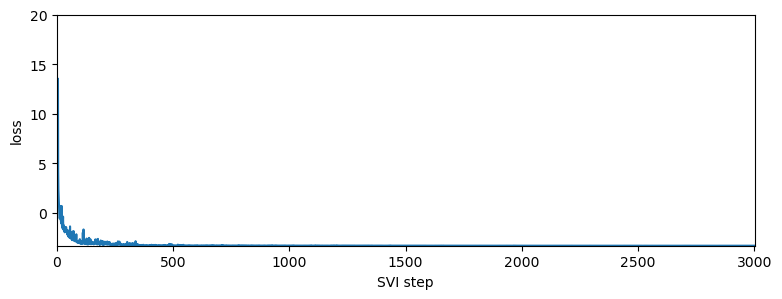

In [14]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)

guide_with_log_prob, losses_with_log_prob, stats_with_log_prob = fit_model(model_with_log_prob)

print("-" * 20)
for name, (lb, ub) in sorted(stats_with_log_prob[-1]):
    if lb.numel() == 1:
        lb = lb.squeeze().item()
        ub = ub.squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

pyplot.figure(figsize=(9, 3))
pyplot.plot(losses_with_log_prob)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
pyplot.xlim(0, len(losses_with_log_prob))
pyplot.ylim(min(losses_with_log_prob), 20)


The log returns exhibit a negative skew which was not captured by the model with reparameterization of the `Stable` distribution. The negative skew means that negative log returns have a heavier tail than the tail of positive log returns. Also the stability parameter is slightly lower than the one found using the model with reparameterization of the `Stable` distribution (lower stability means heavier tails).

Comparing convergence of the two models (see below graphs) we can see that without `Stable` distribution reparameterization less iterations are required for the stability parameter to converge, but since per iteration running times without `Stable` distribution reparameterization is much higher, the overall running time without `Stable` distribution reparameterization is significantly higher.


In [15]:
stability_with_log_prob = []
skew_with_log_prob = []
for stat in stats_with_log_prob:
    stat = dict(stat)
    stability_with_log_prob.append(stat['r_stability'].mean().item())
    skew_with_log_prob.append(stat['r_skew'].mean().item())

stability = []
skew = []
for stat in stats:
    stat = dict(stat)
    stability.append(stat['r_stability'].mean().item())
    skew.append(stat['r_skew'].mean().item())

(1.8, 2.0)

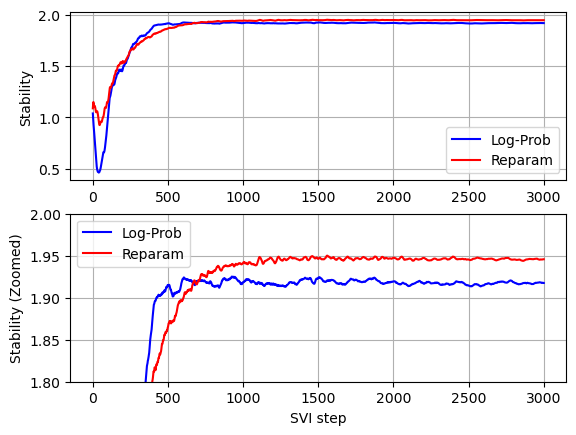

In [16]:
def plot_comparison(log_prob_values, reparam_values, xlabel, ylabel):
    pyplot.plot(log_prob_values, color='b', label='Log-Prob')
    pyplot.plot(reparam_values, color='r', label='Reparam')
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.legend(loc='best')
    pyplot.grid()

pyplot.subplot(2,1,1)
plot_comparison(stability_with_log_prob, stability, '', 'Stability')

pyplot.subplot(2,1,2)
plot_comparison(stability_with_log_prob, stability, 'SVI step', 'Stability (Zoomed)')
pyplot.ylim(1.8, 2)

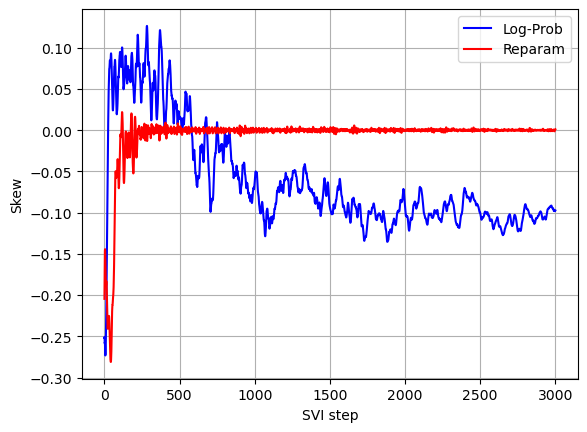

In [17]:
plot_comparison(skew_with_log_prob, skew, 'SVI step', 'Skew')